In [18]:
import pandas as pd 
import datetime
import numpy as np
import sqlite3

csv_file_path = r"C:\Users\nyaga\OneDrive\Desktop\ENDSEM - DSA2040\Online Retail.xlsx" 
current_date = datetime.datetime(2011, 12, 10)
last_year_date = current_date - datetime.timedelta(days=365)
database_name = "retail_dw.db"

#EXTRACTION STAGE
def extract_data(file_path):
    """Reads the UCI Excel file, performs initial cleaning, and time conversion."""
    print(f"Starting Extraction from {file_path}...")
    
    try:
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"ERROR: File not found at {file_path}. Please check the path and try again.")
        return None
        
    initial_rows = len(df)
    print(f" Loaded {initial_rows} rows from the Excel file.")

    # 1. Handle Missing Values: Drop rows with missing CustomerID
    df.dropna(subset=['CustomerID'], inplace=True)
    rows_after_customer_dropna = len(df)
    print(f"Dropped rows with missing CustomerID. Remaining rows: {rows_after_customer_dropna}")

    # 2. Data Type Conversion: Convert InvoiceDate to datetime objects
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
        
    # 3. Convert CustomerID to string
    # We must convert to int first to clean up any floating point representation.
    df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

    # Log the result of the Extraction stage
    print(f"Extraction Complete. Ready for Transformation.")
    return df

In [19]:
#TRANSFORMATION STAGE
def transform_data(df):
    """ Applies transformations: calculations, filtering, outlier handling, dimension key generation, and data structuring."""
    initial_rows = len(df)
    print (f"Starting Transformation on {initial_rows} rows...")
    
    # 1. Calculate new column: TotalSales = Quantity * UnitPrice
    df['TotalSales'] = df['Quantity'] * df['UnitPrice']
    print("Calculated TotalSales for each transaction.")
    
    # 2. Handle outliers: Remove rows where Quantity < 0 or UnitPrice <= 0
    # The negative quantities often represent returns, which we exclude for sales analysis.
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
    rows_after_outlier_removal = len(df)
    print(f"Removed outliers. Remaining rows: {rows_after_outlier_removal}")
    
    # 3. Filter data for sales in the last year (Aug 12, 2024 to Aug 12, 2025)
    df_filtered = df[(df['InvoiceDate'] >= last_year_date)].copy()
    rows_after_date_filter = len(df_filtered)
    print(f"Filtered data for the last year. Remaining rows: {rows_after_date_filter}")
    
    
    # Dimension key generation and surrogate key generation
    # 4. Deriving Product Category (Crucial Step for Dim_Product)
    # Since the UCI file lacks a category, we use a simple keyword mapping for demonstration.
    def get_category(description):
        desc = str(description).lower()
        if any(keyword in desc for keyword in ['bag', 'case', 'box']):
            return 'Accessories'
        if any(keyword in desc for keyword in ['mug', 'cup', 'plate', 'jar']):
            return 'Kitchenware'
        if any(keyword in desc for keyword in ['light', 'candle', 'hook', 'wall']):
            return 'Home Decor'
        return 'Miscellaneous'
    
    df_filtered['ProductCategory'] = df_filtered['Description'].apply(get_category)
    print("   -> Derived ProductCategory based on keywords.")

    # A. Create Product Dimension (Dim_Product)
    product_dim = df_filtered[['ProductCategory']].drop_duplicates().reset_index(drop=True)
    product_dim['Product_Key'] = product_dim.index + 1
    
    # B. Create Customer Dimension (CustomerDim)
    # Grouping to find total purchases/spent, and assigning a synthetic Age for demographics analysis.
    customer_dim = df_filtered.groupby('CustomerID').agg(
        TotalPurchases=('InvoiceNo', 'nunique'), # Count unique invoices
        TotalSpent=('TotalSales', 'sum'),
        Country=('Country', 'first')
    ).reset_index()
    
    customer_dim['Customer_Key'] = customer_dim.index + 1
    # Add synthetic Age (since the UCI file does not have demographics)
    customer_dim['Age'] = np.random.randint(20, 60, size=len(customer_dim)) 
    
    # C. Create Time Dimension (TimeDim)
    time_dim = df_filtered[['InvoiceDate']].drop_duplicates().sort_values('InvoiceDate').reset_index(drop=True)
    time_dim['Date_Key'] = time_dim.index + 1
    time_dim['Full_Date'] = time_dim['InvoiceDate'].dt.date
    time_dim['Year'] = time_dim['InvoiceDate'].dt.year
    time_dim['Quarter'] = time_dim['InvoiceDate'].dt.quarter
    time_dim['Month'] = time_dim['InvoiceDate'].dt.month
    
    # D. Prepare Fact Data: Merge Surrogate Keys
    # We merge the unique dimension keys back into the transaction data (df_filtered)
    
    df_fact = pd.merge(df_filtered, customer_dim[['CustomerID', 'Customer_Key']], on='CustomerID', how='left')
    df_fact = pd.merge(df_fact, time_dim[['InvoiceDate', 'Date_Key']], on='InvoiceDate', how='left')
    df_fact = pd.merge(df_fact, product_dim[['ProductCategory', 'Product_Key']], on='ProductCategory', how='left')

    # Final Fact Table Selection
    sales_fact = df_fact.rename(columns={'InvoiceNo': 'TransactionID'}).reset_index(drop=True)
    sales_fact['Sale_Key'] = sales_fact.index + 1
    
    sales_fact = sales_fact[[
        'Sale_Key', 'Date_Key', 'Customer_Key', 'Product_Key', 
        'TransactionID', 'Quantity', 'UnitPrice', 'TotalSales'
    ]]
    
    print(f"--- Transformation Complete. Fact Rows: {len(sales_fact)} ---")
    
    return sales_fact, customer_dim, time_dim, product_dim

In [20]:
# LOAD STAGE
def create_and_load_db(sales_fact, customer_dim, time_dim, product_dim):
    """Creates SQLite database structure and loads transformed data into tables."""
    print(f"\n--- 3. Starting Loading to {database_name} ---")
    
    # 1. Connect to (or create) the SQLite database
    conn = sqlite3.connect(database_name)
    cursor = conn.cursor()

    # 2. SQL Table Creation (CREATE TABLE statements matching the Star Schema)
    
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS TimeDim (
            Date_Key INTEGER PRIMARY KEY, 
            Full_Date TEXT UNIQUE, 
            Year INTEGER, 
            Quarter INTEGER, 
            Month INTEGER
        );
    """)

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS CustomerDim (
            Customer_Key INTEGER PRIMARY KEY, 
            CustomerID TEXT UNIQUE, 
            TotalPurchases INTEGER, 
            TotalSpent REAL, 
            Country TEXT, 
            Age INTEGER
        );
    """)

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS ProductDim (
            Product_Key INTEGER PRIMARY KEY, 
            ProductCategory TEXT UNIQUE
        );
    """)

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS SalesFact (
            Sale_Key INTEGER PRIMARY KEY, 
            Date_Key INTEGER NOT NULL,
            Customer_Key INTEGER NOT NULL,
            Product_Key INTEGER NOT NULL,
            TransactionID TEXT,
            Quantity INTEGER,
            UnitPrice REAL,
            TotalSales REAL,
            FOREIGN KEY (Date_Key) REFERENCES Dim_Time(Date_Key),
            FOREIGN KEY (Customer_Key) REFERENCES Dim_Customer(Customer_Key),
            FOREIGN KEY (Product_Key) REFERENCES Dim_Product(Product_Key)
        );
    """)

    # 3. Loading Data using pandas to_sql
    
    time_dim.to_sql('TimeDim', conn, if_exists='replace', index=False)
    print(f"   -> Loaded {len(time_dim)} rows into TimeDim.")
    
    customer_dim.to_sql('CustomerDim', conn, if_exists='replace', index=False)
    print(f"   -> Loaded {len(customer_dim)} rows into CustomerDim.")

    product_dim.to_sql('ProductDim', conn, if_exists='replace', index=False)
    print(f"   -> Loaded {len(product_dim)} rows into ProductDim.")
    
    sales_fact.to_sql('SalesFact', conn, if_exists='replace', index=False)
    fact_rows_loaded = len(sales_fact)
    print(f"   -> Loaded {fact_rows_loaded} rows into SalesFact.")
    
    conn.commit()
    conn.close()
    
    print("--- Loading Complete ---")
    return fact_rows_loaded


In [21]:
def perform_full_etl():
    """
    Performs the full ETL pipeline (E, T, L) and logs row counts.
    """
    print("\n=======================================================")
    print("       STARTING RETAIL DATA WAREHOUSE ETL PROCESS")
    print("=======================================================")
    
    try:
        # 1. Extraction (E)
        df_extracted = extract_data(r"C:\Users\nyaga\OneDrive\Desktop\ENDSEM-DSA2040\Online Retail.xlsx")
        if df_extracted is None:
            return 
        print("--- Extraction Complete. Ready for Transformation. ---")

        # 2. Transformation (T)
        # Note: We are using the corrected transform_data signature (without current_date as an arg)
        sales_fact, customer_dim, time_dim, product_dim = transform_data(df_extracted)
        print("--- Transformation Complete. Ready for Loading. ---")
        
        # 3. Loading (L)
        # This function creates and populates the retail_dw.db file
        fact_rows_loaded = create_and_load_db(sales_fact, customer_dim, time_dim, product_dim)
        
        # Final Log
        print("\n ETL Process Successful!")
        print(f"Database file '{database_name}' created and populated.")
        print(f"Final rows loaded to SalesFact: {fact_rows_loaded}")
        
    except Exception as e:
        print(f"\nETL Process Failed due to an error: {e}")
        import traceback
        print(traceback.format_exc())

# This block is what triggers the creation of the DB file when you run the script!
if __name__ == "__main__":
    perform_full_etl()


       STARTING RETAIL DATA WAREHOUSE ETL PROCESS
Starting Extraction from C:\Users\nyaga\OneDrive\Desktop\ENDSEM-DSA2040\Online Retail.xlsx...
 Loaded 541909 rows from the Excel file.
Dropped rows with missing CustomerID. Remaining rows: 406829
Extraction Complete. Ready for Transformation.
--- Extraction Complete. Ready for Transformation. ---
Starting Transformation on 406829 rows...
Calculated TotalSales for each transaction.
Removed outliers. Remaining rows: 397884
Filtered data for the last year. Remaining rows: 383380
   -> Derived ProductCategory based on keywords.
--- Transformation Complete. Fact Rows: 383380 ---
--- Transformation Complete. Ready for Loading. ---

--- 3. Starting Loading to retail_dw.db ---
   -> Loaded 16577 rows into TimeDim.
   -> Loaded 4264 rows into CustomerDim.
   -> Loaded 4 rows into ProductDim.
   -> Loaded 383380 rows into SalesFact.
--- Loading Complete ---

 ETL Process Successful!
Database file 'retail_dw.db' created and populated.
Final rows 


Chart saved successfully as sales_by_country_chart.png


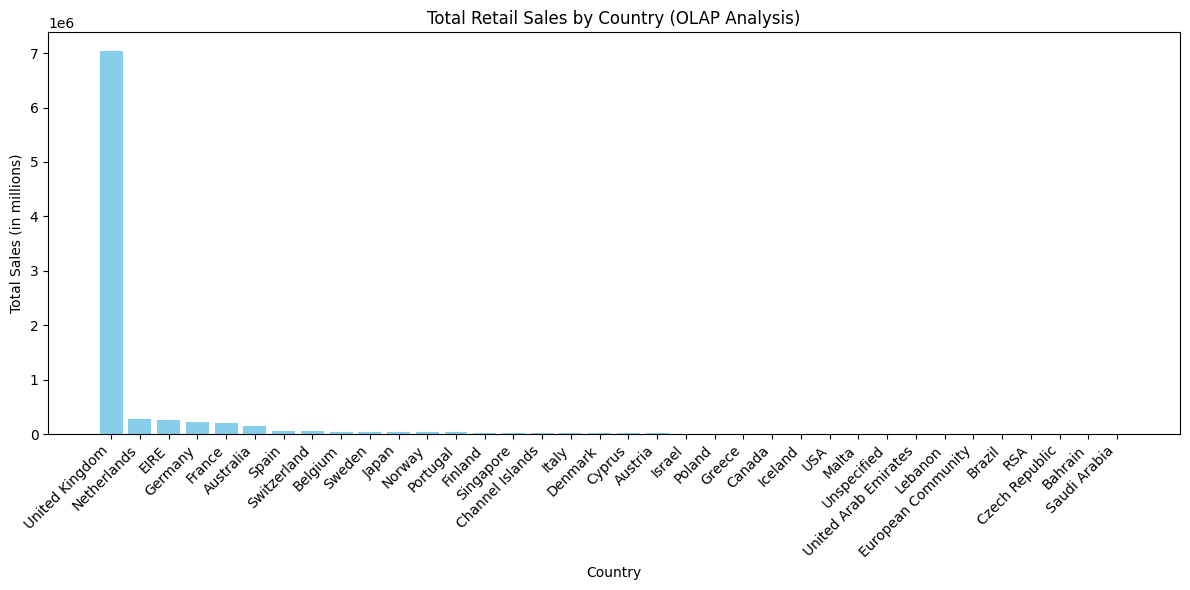

In [22]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

database_name = 'retail_dw.db'

def visualize_sales_by_country():
    """Executes a query to get total sales by country and creates a bar chart."""
    conn = sqlite3.connect(database_name)
    
    # SQL Query to get total sales aggregated by Country
    query_sales_by_country = """
    SELECT
        cd.Country,
        SUM(fs.TotalSales) AS TotalSales
    FROM
        SalesFact fs
    JOIN
        CustomerDim cd ON fs.Customer_Key = cd.Customer_Key
    GROUP BY
        cd.Country
    ORDER BY
        TotalSales DESC;
    """
    
    # Execute query and load results into a Pandas DataFrame
    df_sales = pd.read_sql_query(query_sales_by_country, conn)
    conn.close()
    
    if df_sales.empty:
        print("No data found for visualization.")
        return

    # Create the visualization
    plt.figure(figsize=(12, 6))
    plt.bar(df_sales['Country'], df_sales['TotalSales'], color='skyblue')
    plt.xlabel('Country')
    plt.ylabel('Total Sales (in millions)')
    plt.title('Total Retail Sales by Country (OLAP Analysis)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save the chart as an image file
    image_file_path = 'sales_by_country_chart.png'
    plt.savefig(image_file_path)
    print(f"\nChart saved successfully as {image_file_path}")
    
# Run the visualization function
visualize_sales_by_country()
